# Import Libraries and Tools

In [ ]:
import os                                                                                                              # For directory and file operations
import numpy as np                                                                                           # For numerical operations and handling image arrays
import random                                                                                                    # For generating random values for augmentation
from PIL import Image, ImageEnhance                                                          # For image processing and enhancement
import matplotlib.pyplot as plt                                                                         # For image/data representation
import seaborn as sns                                                                                       # For image/data representation


# Keras
from tensorflow.keras.models import Sequential                                        # For building the model
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout         # For model layers
from tensorflow.keras.preprocessing.image import load_img, img_to_array# For loading images
from tensorflow.keras.optimizers import Adam                                           # For optimizer
from tensorflow.keras.applications import VGG16                                      # For using VGG16 model
from tensorflow.keras.models import load_model                                      # To load a saved Keras model (e.g., from a .h5 or SavedModel directory)

# Scikit-learn
from sklearn.utils import shuffle                                                                                                    # For shuffling the data
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc         # For evaluating model performance with metrics like precision, recall, F1-score, confusion matrix, and ROC-AUC
from sklearn.preprocessing import label_binarize                                                                     # Converts labels to one-hot encoding format (needed for multi-class ROC-AUC calculation)

# Load Datasets

In [ ]:
# Directories for training and testing data
train_dir = '/content/drive/MyDrive/MRI Images/Training/'
test_dir = '/content/drive/MyDrive/MRI Images/Testing/'

In [ ]:
# Load and shuffle the train data
train_paths = []
train_labels = []

for label in os.listdir(train_dir):
  for image in os.listdir(os.path.join(train_dir, label)):                               # Eg. '/content/drive/MyDrive/MRI Images/Training/glioma/'
    train_paths.append(os.path.join(train_dir, label, image))                     # Eg. '/content/drive/MyDrive/MRI Images/Training/glioma/Tr-me_1268.jpg'
    train_labels.append(label)                                                                         # Eg. glioma

train_paths, train_labels = shuffle(train_paths, train_labels)
train_paths;

In [ ]:
len(train_paths)

5732

In [ ]:
# Load and shuffle the test data
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
  for image in os.listdir(os.path.join(test_dir, label)):
    test_paths.append(os.path.join(test_dir, label, image))
    test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)
test_paths;

In [ ]:
len(test_paths)

1311

# Data Visualization

In [ ]:
# Select random indices for 10 images
random_indices = random.sample(range(len(train_paths)), 10)
random_indices

[23, 4253, 3592, 2707, 27, 2243, 5262, 1100, 4656, 3990]

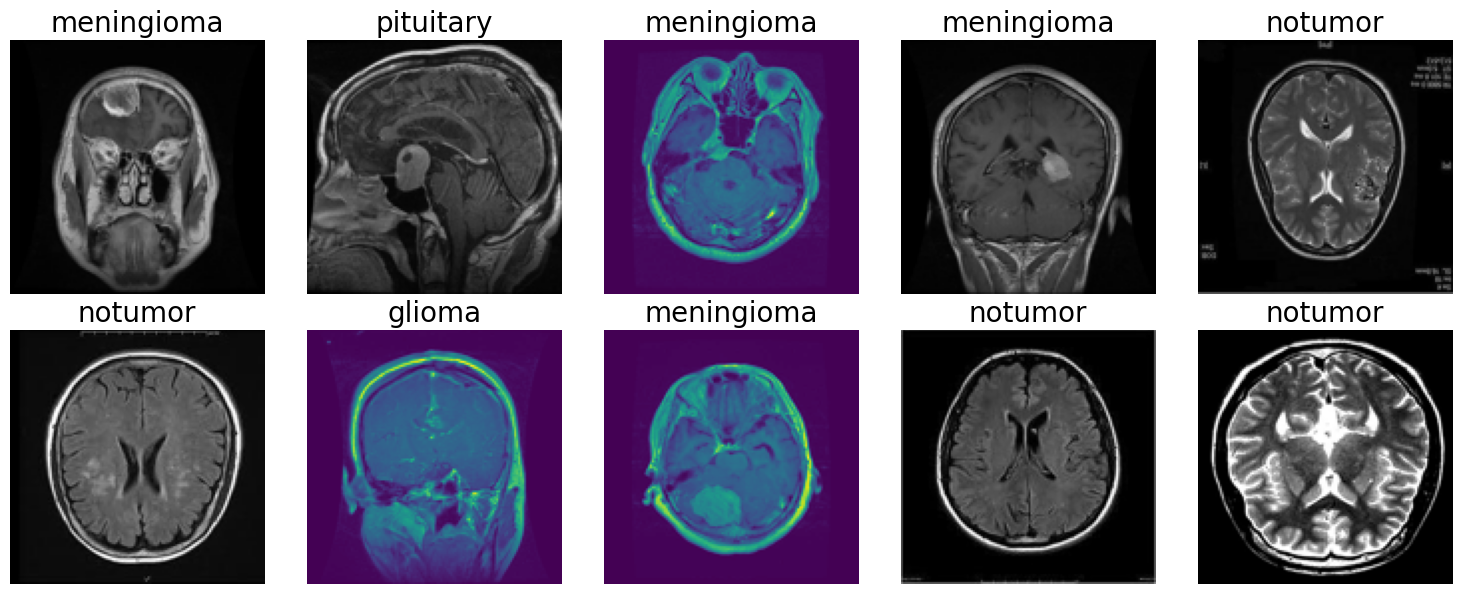

In [ ]:
# Create a figure to display
fig, axes = plt.subplots(2, 5, figsize = (15, 6))
axes = axes.ravel()                                                         # Flatten the 2D array of subplot axes into a 1D array for easier indexing

# Loop through the random indices and display the image
for i, idx in enumerate(random_indices):
  img_path = train_paths[idx]
  img = Image.open(img_path)
  img = img.resize((128, 128))

  # Display images
  axes[i].imshow(img)
  axes[i].axis('off')
  axes[i].set_title(f'{train_labels[idx]}', fontsize = 20)

plt.tight_layout()    # To adjust the spacing automatically between subplots.
plt.show()

# Image Preprocessing (Helper Functions)

In [ ]:
# Image Augmentation Function
def augment_image(image):
  image = Image.fromarray(np.uint8(image))                                                                         # Convert the input NumPy image array to a PIL Image for easier enhancement
  image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))        # Randomly adjust the brightness of the image between 80% to 120%
  image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))           # Randomly adjust the contrast of the image between 80% to 120%
  image = np.array(image)/255.0                                                                                           # Convert the augmented PIL image back to NumPy array and normalize pixel values [0, 1]
  return image


# Load images and apply augmentation
def open_images(paths):
    images = []
    for path in paths:
        img = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        img = np.array(img)                                                                                                          # Convert to NumPy array
        img = augment_image(img)                                                                                           # Augment and normalize
        images.append(img)                                                                                                      # Add img to images
    return np.array(images, dtype=np.float32)                                                                    # Return image batch


# Convert strings into integers (Convert labels into integers)
def encode_label(labels):
    unique_labels = sorted(os.listdir(train_dir))                                                       # Keep consistent ordering
    encoded = [unique_labels.index(label) for label in labels]                              # labels is a list of strings
    return np.array(encoded, dtype=np.int32)


# Data generator for batching
def datagen(paths, labels, batch_size=12, epochs=1):
    while True:
        for i in range(0, len(paths), batch_size):                                                  # Iterate through the dataset in steps of batch_size
            batch_paths = paths[i: i + batch_size]                                                 # Get the image paths for the current batch
            batch_labels = labels[i: i + batch_size]                                               # Get the corresponding labels for the current batch
            batch_images = open_images(batch_paths)                                   # Load, resize, augment, and normalize images
            batch_labels = encode_label(batch_labels)                                     # Convert string labels into integer class indices
            yield batch_images, batch_labels                                                     # Both should be NumPy arrays

# Model Building

In [ ]:
  # Model Architecture (128, 128, 3)

IMAGE_SIZE = 128
base_model = VGG16(input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3), include_top = False, weights = 'imagenet')

# Freeze all layers of the VGG16 base model
for layer in base_model.layers:
 layer.trainable = False

# Set only the last few layers
base_model.layers[-2].trainable = True  # Allowing 2nd last layer
base_model.layers[-3].trainable = True  # Allowing 3rd last layer
base_model.layers[-4].trainable = True  # Allowing 4th last layer

#Build model
model = Sequential()                                                                                     # Initialize a sequential model (stacking layers one after the other )
model.add(Input(shape = (IMAGE_SIZE, IMAGE_SIZE, 3)))                   # Define the input shape for the model (128 x 128 RGB image)
model.add(base_model)                                                                             # Add the pre-trained VGG16 model (without the top layers) as a feature extractor
model.add(Flatten())                                                                                   # Flatten the output from the convolution base into a 1D vector for dense layers
model.add(Dropout(0.3))                                                                           # Randomly turns 30% of the neurons off to prevent overfitting
model.add(Dense(128, activation = 'relu'))                                             # A normal layer with 128 neurons to learn patterns from the image features
model.add(Dropout(0.2))                                                                          # Randomly turns 20% of the neurons off to prevent overfitting
model.add(Dense(len(os.listdir(train_dir)), activation = 'softmax'))  # Output layer


# Compile the model
model.compile(optimizer = Adam(learning_rate = 0.0001), loss = 'sparse_categorical_crossentropy', metrics = ['sparse_categorical_accuracy'])


# Parameters
batch_size = 20                                                                                          # This means we'll train the model using 20 images at a time
steps = int(len(train_paths) / batch_size)                                             # steps = how many batches it takes to teach the full class
epochs = 5                                                                                                 # The model will go through the **entire training dataset** 5 times


# Train the model
history = model.fit(
    datagen(train_paths, train_labels, batch_size = batch_size, epochs = epochs),
    steps_per_epoch = steps,
    epochs = 5
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
286/286 ━━━━━━━━━━━━━━━━━━━━ 1523s 5s/step - loss: 0.6488 - sparse_categorical_accuracy: 0.7345
Epoch 2/5
286/286 ━━━━━━━━━━━━━━━━━━━━ 1440s 5s/step - loss: 0.2615 - sparse_categorical_accuracy: 0.8990
Epoch 3/5
286/286 ━━━━━━━━━━━━━━━━━━━━ 1444s 5s/step - loss: 0.1706 - sparse_categorical_accuracy: 0.9404
Epoch 4/5
286/286 ━━━━━━━━━━━━━━━━━━━━ 1441s 5s/step - loss: 0.1304 - sparse_categorical_accuracy: 0.9508
Epoch 5/5
286/286 ━━━━━━━━━━━━━━━━━━━━ 1429s 5s/step - loss: 0.1073 - sparse_categorical_accuracy: 0.9555


# Train and Val Plots

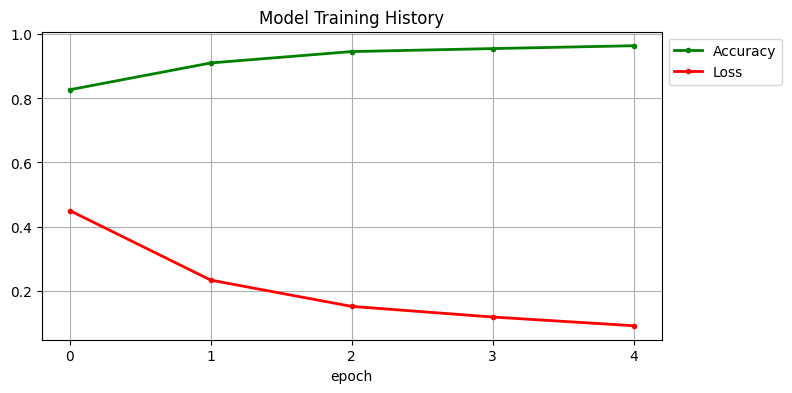

In [ ]:
plt.figure(figsize = (8, 4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth = 2)
plt.plot(history.history['loss'], '.r-', linewidth = 2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy','Loss'], loc = 'upper left', bbox_to_anchor = (1, 1))
plt.show()

# Model Classification Report

In [ ]:
# Prediction on test data
test_images = open_images(test_paths)                                         # Load, resize, augment, and normalize all test images from their file paths
test_labels_encoded = encode_label(test_labels)                         # Convert test labels from strings to integer-encoded format


# Predict on trained model
test_predictions = model.predict(test_images)                          # Use the trained model to get prediction probabilities for each test image


# Classification report
print('Classification Report : ')
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))                 # Print precision, recall, f1-score using predicted vs actual labels

41/41 ━━━━━━━━━━━━━━━━━━━━ 268s 6s/step
Classification Report : 
              precision    recall  f1-score   support

           0       0.94      0.95      0.94       300
           1       0.92      0.96      0.94       306
           2       0.99      0.99      0.99       405
           3       1.00      0.95      0.98       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311



# Model Confusion Plot

In [ ]:
# Confusion matrix
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis = 1))              # Creates a confusion matrix comparing true vs predicted class indices
print('Confusion Matrix : ')
print(conf_matrix)

Confusion Matrix : 
[[284  16   0   0]
 [ 10 294   2   0]
 [  6   0 399   0]
 [  3  10   1 286]]


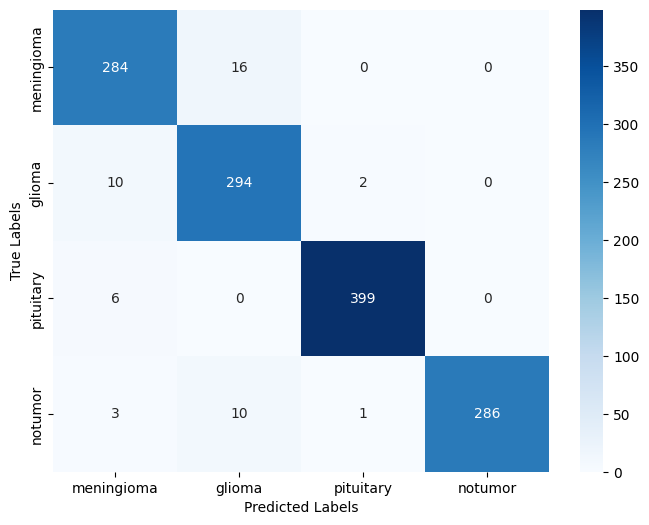

In [ ]:
# Plotting the confusion matrix
plt.figure(figsize =(8, 6))
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = os.listdir(train_dir), yticklabels = os.listdir(train_dir))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# ROC Curve Plot

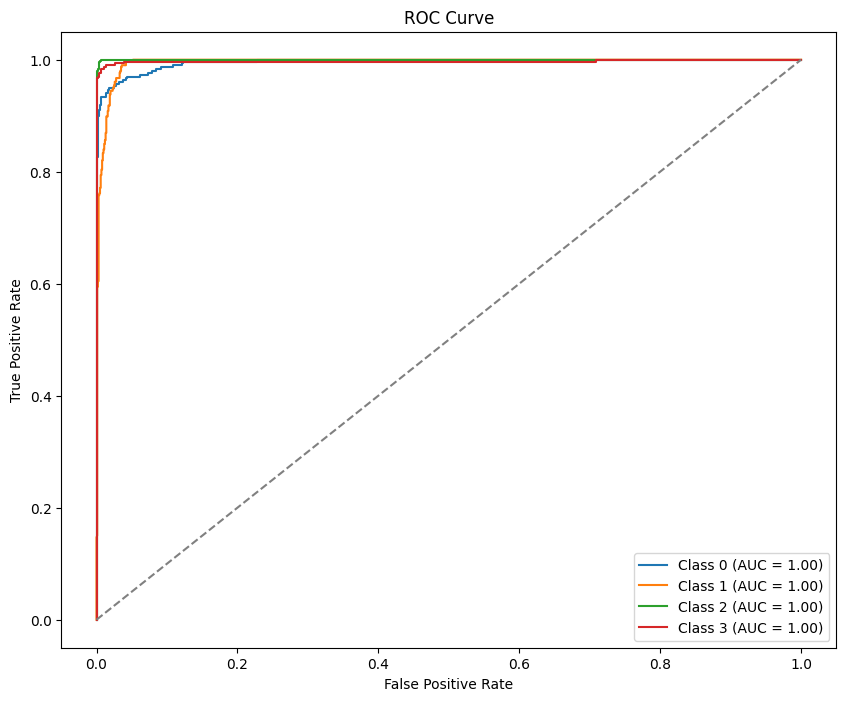

In [ ]:
# Binarize the test labels and predictions for multi-class ROC
test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(len(os.listdir(train_dir))))
test_predictions_bin = test_predictions


# Compute ROC curve and ROC AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(os.listdir(train_dir))):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(len(os.listdir(train_dir))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

# Save and Load Model

In [ ]:
# Save the entire model
model.save('model.h5')

In [ ]:
# Load the trained model
model = load_model('model.h5')

# MRI Tumor Detection System

In [ ]:
# Class labels
class_labels = ['pituitary', 'glioma','notumor','meningioma']


# Function
def detect_and_display(img_path, model, image_size = 128):
  try:
    # Load and process the image
    img = load_img(img_path, target_size = (image_size, image_size))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis = 0)

    #Make a prediction
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions, axis = 1)[0]
    confidence_score = np.max(predictions, axis =1)[0]

    # Determine the class
    if class_labels[predicted_class_index] == 'notumor':
      result = 'No Tumor'
    else:
      result = f'Tumor : {class_labels[predicted_class_index]}'

    # Display the image with prediction
    plt.imshow(load_img(img_path))
    plt.axis('off')
    plt.title(f'{result} (Confidence : {confidence_score*100:.2f}%)')
    plt.show()

  except Exception as e:
    print('Error processing the image :', str(e))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


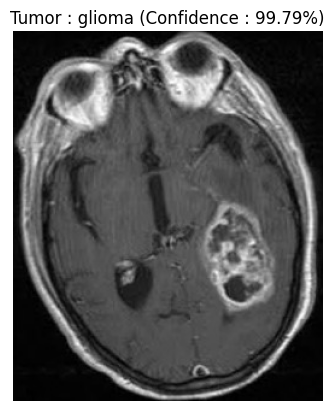

In [ ]:
# 1. Example
image_path = '/content/drive/MyDrive/MRI Images/Testing/meningioma/Te-meTr_0001.jpg'
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


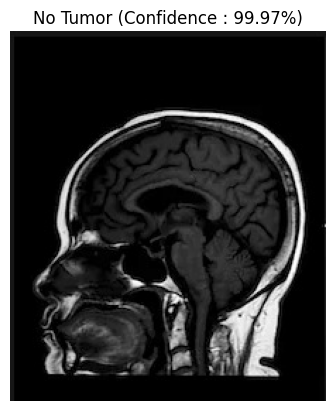

In [ ]:
# 2. Example
image_path = '/content/drive/MyDrive/MRI Images/Testing/notumor/Te-noTr_0004.jpg'
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


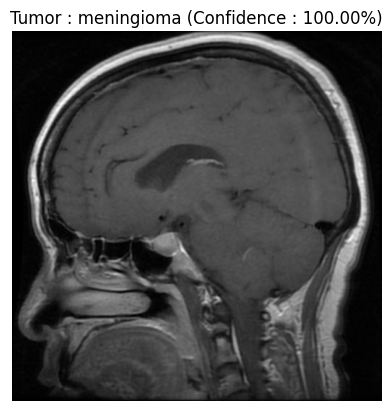

In [ ]:
# 3. Example
image_path = '/content/drive/MyDrive/MRI Images/Testing/pituitary/Te-piTr_0003.jpg'
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


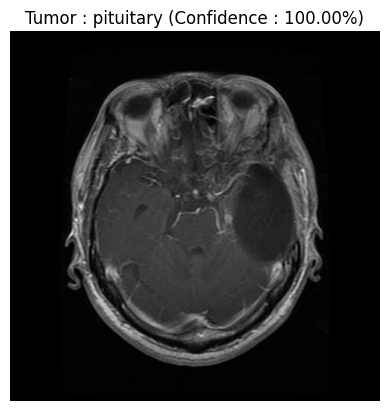

In [ ]:
# 4. Example
image_path = '/content/drive/MyDrive/MRI Images/Testing/glioma/Te-gl_0015.jpg'
detect_and_display(image_path, model)